In [1]:
import sys
import matplotlib.pyplot as plt

In [2]:
# fetch from local path otherwise fetch from the remote path (if remote kernel is being used)
try: 
    sys.path.append('../../scripts')
    import utils
    import spark
except:
    try:
        sys.path.append('./scripts')
        import utils
        import spark
    except:
        raise RuntimeError('Failed to import from both local and remote paths. Program terminated.')

# First Hypothesis
In the following notebook it will be analyzed the following hypothesis:
 - **Does the length of the tweets, have an impact on the positivity or negativity of the review?**

In [3]:
spark = spark.setup_spark_session(app_name='Hypothesis 1')

In [4]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import pyspark.sql.functions as F
# Define the schema
schema = StructType([
    StructField('target', IntegerType(), True),
    StructField('text', StringType(), True),
])

In [5]:
df = spark.read.csv("hdfs://localhost:54310/user/datascience/data/processed/final_tweets_preprocessed", header=False, schema=schema, sep="\t")

In [6]:
df.limit(5).toPandas()

/home/datascience/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


,target,text
0,0,awww that bummer shoulda got david carr third day
1,0,upset cant updat facebook text might cri resul...
2,0,dive mani time ball manag save rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav im mad cant see


### Metrics (length)
For performing this analysis, we obtain the length of each tweet and  include it as an additional column in the dataframe.

In [7]:
df = df.withColumn('length', F.length('text'))

In [8]:
df.limit(5).toPandas()

,target,text,length
0,0,awww that bummer shoulda got david carr third day,49
1,0,upset cant updat facebook text might cri resul...,70
2,0,dive mani time ball manag save rest go bound,44
3,0,whole bodi feel itchi like fire,31
4,0,behav im mad cant see,21


In [9]:
df.select('target', 'length').summary().show()

+-------+------------------+------------------+
|summary|            target|            length|
+-------+------------------+------------------+
|  count|           1591422|           1591422|
|   mean|0.4999937163115754|39.281248468350945|
| stddev|0.5000001570527857|22.045368669610248|
|    min|                 0|                 1|
|    25%|                 0|                21|
|    50%|                 0|                36|
|    75%|                 1|                55|
|    max|                 1|               165|
+-------+------------------+------------------+



# Correlation Test
We are using Pearson's correlation coefficient test to find out whether we have positive correlation or negative correlation with the length of the tweet.

In [10]:
# Piersen correlation
coefficient = df.stat.corr('target', 'length', method='pearson')

# Interpretation of the Resuts
Since the value of the coefficient is close to zero it means that it has a very weak correlation.

In [11]:
print(f'Pearson correlation coefficient: {coefficient:.4f}')

Pearson correlation coefficient: -0.0388


# Effect Size
To invalidate the significance fallacy, we used Cohen's d test to see the effect size for the two groups.

In [12]:
group1 = df.filter(df['target'] == 0)
group2 = df.filter(df['target'] == 1)
cohen_d = utils.cohen_d_spark(group1, group2, 'length', 'length')
print(f'Cohen\'s d: {cohen_d:.4f}') 

Cohen's d: 0.0776


# Interpretation of Cohen's d:
 - Cohen's d values around 0.2 are considered small effect sizes.
 - Values around 0.5 represent medium effect sizes.
 - Values of 0.8 or higher indicate large effect sizes.

The effect size obtained is close to zero, which suggests extremely small effect size. Therefore, there is very little difference between the means of the two groups relative to the variablity within the groups. We can infer that the difference between the two groups is only statistically significant, not practically significant.

## Visualization of the Tweet Length Distribution by sentiment

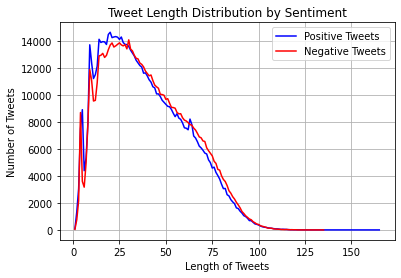

In [13]:
# Separate positive and negative tweets
positive_tweets = df.filter(df['target'] == 1)
negative_tweets = df.filter(df['target'] == 0)

# Group positive and negative tweets by their length and count the occurrences
positive_tweet_length_counts = positive_tweets.groupBy('length').count().orderBy('length')
negative_tweet_length_counts = negative_tweets.groupBy('length').count().orderBy('length')

# Extract the lengths and counts of Pyspark dataframes to Python lists
positive_lengths = positive_tweet_length_counts.select('length').toPandas()['length'].tolist()
positive_counts = positive_tweet_length_counts.select('count').toPandas()['count'].tolist()

negative_lengths = negative_tweet_length_counts.select('length').toPandas()['length'].tolist()
negative_counts = negative_tweet_length_counts.select('count').toPandas()['count'].tolist()

plt.plot(positive_lengths, positive_counts, color='blue', label='Positive Tweets')
plt.plot(negative_lengths, negative_counts, color='red', label='Negative Tweets')
plt.xlabel('Length of Tweets')
plt.ylabel('Number of Tweets')
plt.title('Tweet Length Distribution by Sentiment')
plt.legend()
plt.grid(True)
plt.show()

In the above graph, we can see that the two lines for the different sentiment are almost identical. There might be a little difference in the shorter length tweets that tends to be positive but overall the two lines overal significantly. Hence, we can conclude that there might be not be a signifant influence of the tweets' length on the sentiment.

In [14]:
spark.stop()